In [2]:
#!pip install -q tfp-nightly

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from catboost import CatBoostRegressor
import tensorflow as tf
#import tensorflow_probability as tfp
#from tensorflow_probability import edward2 as ed
#tfd = tfp.distributions


sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

TODO: intro

In [28]:
train = pd.read_csv('../input/train.csv', 
                    usecols=np.arange(1, 7),
                    nrows=200000)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],
                                          format='%Y-%m-%d %H:%M:%S %Z')

In [29]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762


Let's take a look at how many null values there are in each column.

In [31]:
print('Column\tPercent Null')
for col in train:
    print(col, 100*train[col].isnull().sum()/train.shape[0])

Column	Percent Null
fare_amount 0.0
pickup_datetime 0.0
pickup_longitude 0.0
pickup_latitude 0.0
dropoff_longitude 0.0005
dropoff_latitude 0.0005


There are some null values, but a negligible amount of them, so we'll simply remove rows with null values.

In [32]:
train.dropna(inplace=True)

Have to extract time of day, time of week, time of year, and year, and then drop the original datetime column.

In [33]:
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute)
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['year'] = train['pickup_datetime'].dt.year
train.drop('pickup_datetime', axis=1, inplace=True)

In [34]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1046,0,166,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1012,1,5,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,35,3,230,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,270,5,112,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,471,1,68,2010


Let's check the fare amount distributions:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


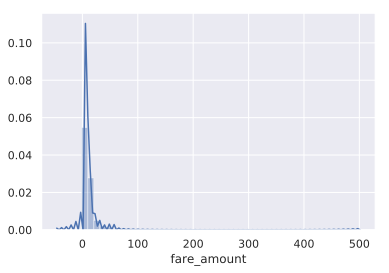

In [35]:
# Plot distribution of fares
sns.distplot(train['fare_amount'])
plt.show()

It looks like there might be some negative values (which doesn't make any sense, of course!). Let's zoom in on the area around 0.

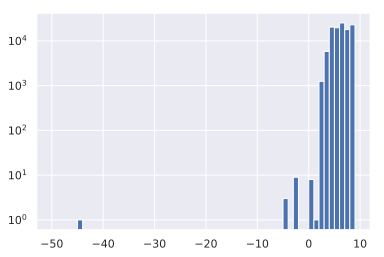

In [36]:
# Plot distribution of fares around 0
plt.hist(train['fare_amount'], 
         bins=np.arange(-50, 10), log=True)
plt.show()

Let's remove the datapoints with fares which are suspiciously low, and also rides with suspiciously high fares.

In [37]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove rows with outlier fare values
train = clip(train, 1, 200, ['fare_amount'])

Finally, let's check the locations of the pickups and dropoffs.

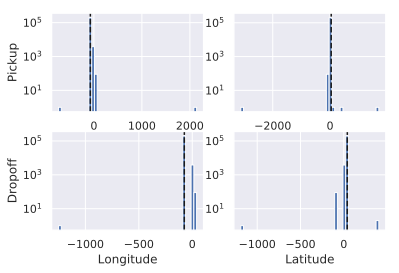

In [38]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

There are some outliers, especially at 0.  Let's remove rows with geographical locations outside a reasonable range (near the greater NYC metropolitan area).

In [39]:
# Remove geographical outliers
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

And now we have only values which are near NYC:

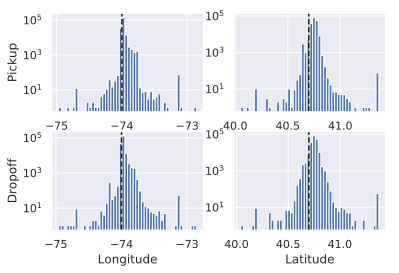

In [40]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

## Baseline Model

xgboost

In [74]:
# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

How well do we do if we just predict the mean?

In [70]:
# Just predict the mean
m_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', DummyRegressor())
])

# MAE from predicting just the mean
scores = cross_val_score(m_pipeline, 
                         x_taxi, y_taxi, cv=3,
                         scoring=mae_scorer)
print('Dummy MAE:', scores.mean())

Dummy MAE: 5.998819370125794


And if we just use the distance of the trip as a predictor?

In [138]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(train['pickup_longitude'] -
             train['dropoff_longitude'], 2) + 
    np.power(train['pickup_latitude'] - 
             train['dropoff_latitude'], 2))

# Just use distance as predictor
ir = IsotonicRegression(out_of_bounds='clip')

# MAE from using just distance as predictor
scores = cross_val_score(ir, 
                         dist, y_taxi, cv=3,
                         scoring=mae_scorer)
print('Isotonic MAE:', scores.mean())

Isotonic MAE: 2.3585265138356504


And we can do a little better if we use gradient boosted decision trees.

In [63]:
# Classification pipeline w/ catboost predictor
cb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', CatBoostRegressor(logging_level='Silent'))
])

# Cross-validated MAE w/ CatBoost
scores = cross_val_score(cb_pipeline, 
                         x_taxi, y_taxi, cv=3,
                         scoring=mae_scorer)
print('CatBoost MAE:', scores.mean())

CatBoost Mean MSE: 2.0684961083628193
